# **Machine Learning Group Project:** Recommender System Preparation

The purpose of this notebook is to extract content-based similarities across different products on the basis of the plethora of of textual data contained in descriptive columns such as _tags_, _genres_, _description_, or _steamspy_tags_. These findings can later be utilized when building other models.

In [52]:
# General
import requests
import string
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# Visualization
import seaborn as sns
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Parallelization
from joblib import Parallel, delayed

## Content-Based Similarity

### Text Data DataFrame

First we create a DataFrame that contains all instances of descriptive textual data for the products. There is a single entry for each game. We run an inner merge because this is the same kind of merge done between these datasets for the final_df in [a_csv_creation.ipynb](a_csv_creation.ipynb). Consequently, this ensures the data we are working with is compatible with other work later on.

In [53]:
# Import the final DataFrame
textual_df = pd.read_csv("data/final_df.csv", 
                       usecols = ["app_id", "title",
                                  "categories", "genres",
                                  "steamspy_tags", "description",
                                  "tags"])

In [57]:
textual_df.drop_duplicates(subset=['title'], inplace=True)
textual_df.reset_index(drop = True, inplace = True)

textual_df.head(3)

,app_id,title,description,tags,genres,steamspy_tags,categories
0,304390,FOR HONOR™,Carve a path of destruction through an intense...,"['Medieval', 'Swordplay', 'Action', 'Multiplay...",Action,Medieval;Action;Swordplay,Single-player;Online Multi-Player;Online Co-op...
1,306130,The Elder Scrolls® Online,Join over 20 million players in the award-winn...,"['RPG', 'MMORPG', 'Open World', 'Adventure', '...",Massively Multiplayer;RPG,RPG;Open World;MMORPG,MMO;Steam Trading Cards;Partial Controller Sup...
2,238960,Path of Exile,"You are an Exile, struggling to survive on the...","['Free to Play', 'Action RPG', 'Hack and Slash...",Action;Adventure;Free to Play;Indie;Massively ...,Free to Play;Action RPG;Hack and Slash,Single-player;Multi-player;Online Multi-Player...


### Data Preparation

#### Text Homogenization

The first step undertaken is homgenizing the text across the different columns. We do the following:
- Make all words fully lowercase
- Transform the _tags_ column from a list to a string
- Remove separators in the strings of columns such as _categories_, _steamspy_tags_, etc.
- Remove any other punctuation
- Homogenize words with spelling discrepancies (e.g. multiplayer & multi-player)

Note that we do not remove duplicates (e.g. a game being described as "Action" under _genres_ and _steamspy_tags_) because we believe if a word is utilized by more than one source, it should have a stronger weight when vectorizing. 

In [58]:
# Turn to String
textual_df["tags"] = textual_df["tags"].astype(str)

# Remove all punctuation and make everything lowercase
textual_df["tags"] = textual_df["tags"].str.translate(str.maketrans('', '', string.punctuation)).str.lower()

In [59]:
# Use vectorized operations to remove separators from list columns and turn all to lowercase
for col in ["categories", "genres", "steamspy_tags", "tags"]:
    textual_df[col] = textual_df[col].str.replace(';', ' ').str.lower()

    textual_df[col] = textual_df[col].str.replace("multi-player", "multiplayer")\
        .str.replace("free to play", "free-to-play").str.replace("singleplayer", "single-player")\
        .str.replace("post-apocalyptic", "postapocalyptic").str.replace("scifi", "sci-fi")\
        .str.replace("anti cheat", "anti-cheat").str.replace("early access", "early-access")\
        .str.replace("shared/split screen", "shared/split-screen").str.replace(" &", "")\
        .str.replace("sexual content", "sexual").str.replace(" (require", "").str.replace(" hl2)", "")\
        .str.replace("massively multiplayer", "massive-multiplayer")\
        .str.replace("in-app purchases", "in-app-purcases").str.replace("perma death", "permadeath")\
        .str.replace("third person", "third-person").str.replace("multiple endings","multi-ending")\
        .str.replace("1990's", "1990s").str.replace("25d", "2.5d").str.replace("shoot 'em", "shoot'em")

In [10]:
# Define punctuation and numbers
punc = '''!()[]{};:'"\,<>./?@#$%^&*_~'''
num = '0123456789'

# Remove punctuation, numbers, and turn description to lowercase 
textual_df["description"] = textual_df["description"].str.replace(f'[{punc+num}]', '', regex=True)\
    .str.lower().str.replace("multi-player", "multiplayer")

#### Stopword Removal

Although columns like _categories_, _genres_, _steamspy_tags_, and _tags_ do not suffer from this issue, the _description_ column contains stopwords which could be detrimental to our analysis. The stopword list is obtained from a separate [GitHub project](https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt).

In [11]:
# Obtain stopwords
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 

# Remove Stopwords
textual_df['description'] = textual_df['description']\
.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

#### Full Text Column Creation

Finally, we create a new column which contains all the textual information we have on a game.   

In [12]:
textual_df['full_text'] = textual_df['categories'] + ' ' + textual_df['genres'] + ' ' + textual_df['steamspy_tags'] + ' ' + textual_df['description'] + ' ' + textual_df['tags']

### Text Data Exploration

We dedicate a section to exploring text data and truly understanding the breadth of data and labels which are available on textual_df.

**Number of Distinct Labels:** All four labelling columns feature different tag systems with wholly different labels (and variety thereof). Here we check how these vary in terms of numbers. While _categories_ and _genres_ have a relatively restrained count of unique labels (41 and 25 respectively), _tags_ and _steamspy_tags_ have much greater breadth (with 479 and 373 respectively). 

In [13]:
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    split_count = len(textual_df[i].str.split(' ', expand=True).stack().unique())
    print(f"The \033[1m'{i}' column\033[0m features a total of \033[1m{split_count} distinct labels\033[0m.")

The 'categories' column features a total of 35 distinct labels.
The 'genres' column features a total of 23 distinct labels.
The 'steamspy_tags' column features a total of 169 distinct labels.
The 'tags' column features a total of 375 distinct labels.


**Average Number of Labels per Game:** While there is a great difference in the number of unique labels, the average number of labels assigned to a single game is on average quite stable. In fact, _genres_, _steamspy_tags_, and _tags_ all approximately have the same number of labels per row (to two decimal figures). Despite having the second lowest number of different labels, _categories_ has the highest number of labels per row: 8.12.

In [14]:
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    
    split = [len(j) for j in textual_df[i].str.split(' ', expand=True).stack()]
    split_mean = sum(split) / len(split)
    
    print("The entries in the\033[1m", f"'{i}'", "column\033[0m have an approximate average of\033[1m", 
          round(split_mean,2), "labels per row\033[0m.") 

The entries in the 'categories' column have an approximate average of 7.74 labels per row.
The entries in the 'genres' column have an approximate average of 7.9 labels per row.
The entries in the 'steamspy_tags' column have an approximate average of 7.15 labels per row.
The entries in the 'tags' column have an approximate average of 7.16 labels per row.


**Most Common Labels:** AAAAA WE INVESTIGATE

In [15]:
for i in ["categories", "genres", "steamspy_tags", "tags"]:
    
    split_count = textual_df[i].str.split(' ', expand=True).stack().value_counts()
    
    print("The most frequently recurring tags (along with their occurrence) in the", f"'{i}'",
          "column:", f"\n{split_count.nlargest(10)}\n")

The most frequently recurring tags (along with their occurrence) in the 'categories' column: 
steam            660
multiplayer      310
single-player    266
support          213
achievements     212
controller       206
trading          186
cards            186
co-op            172
online           163
Name: count, dtype: int64

The most frequently recurring tags (along with their occurrence) in the 'genres' column: 
action                 171
indie                  110
adventure               95
simulation              89
rpg                     75
strategy                75
early-access            52
free-to-play            41
massive-multiplayer     40
casual                  27
Name: count, dtype: int64

The most frequently recurring tags (along with their occurrence) in the 'steamspy_tags' column: 
action          68
world           55
strategy        54
early-access    52
multiplayer     51
rpg             50
open            48
survival        37
free-to-play    36
simulation    

**Tag Intersection:** Finally, we check if there are certain tags which exist in multiple columns (e.g. "action" being an entry in the _genres_, but also in _tags_. We find that there are AAAAAAAAAA

In [16]:
# Get the unique values in each column
categories = set(textual_df['categories'].str.split(' ').explode().str.strip())
tags = set(textual_df['tags'].str.split(' ').explode().str.strip())
steamspy_tags = set(textual_df['steamspy_tags'].str.split(' ').explode().str.strip())
genre = set(textual_df['genres'].str.split(' ').explode().str.strip())

# Find the intersection of the sets to get the values that exist in all four columns
or_intersection = categories | tags | steamspy_tags | genre
and_intersection = categories & tags & steamspy_tags & genre

# Print the number of unique values that exist in all four columns
print("The number of labels present in at least two columns is:", len(or_intersection))
print("The number of labels present in all four columns is:", len(and_intersection))

The number of labels present in at least two columns is: 410
The number of labels present in all four columns is: 0


#### Textual Data Vectorization

First we create a vector containing information concerning the textual descriptions of the games. We display the first three rows of the resulting array in the form of a fully labelled DataFrame with indexation and column names.

In [17]:
# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = "english",
                            strip_accents = "ascii")

# Fit and transform full text column
fulltext_vector = vectorizer.fit_transform(textual_df['full_text'])
fulltext_array = fulltext_vector.toarray()

# Get the feature names
feature_names = vectorizer.vocabulary_.keys()

# Create DataFrame
vector_df = pd.DataFrame(fulltext_array, columns = feature_names,
                        index = textual_df["title"])
vector_df.head(3)

,single,player,online,multiplayer,op,steam,trading,cards,app,purcases,...,bloodfall,66,revamps,mishima,unreal,duels,aggression,flipping,mods,unlimited
title,,,,,,,,,,,,,,,,,,,,,
FOR HONOR™,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
Project Zomboid,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.127842,0.184334,0.170141,0.0,0.0
Wallpaper Engine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0


#### Optimal Component Selection: Scree Test

The ultimate objective is to utilize Truncated Singular Value Decomposition to reduce the textual data's dimensionality and create a latent matrix. In order to do that, we conduct a Scree Test to determine the optimal number of components to be used. We decide that we want at least 90% of variance being explained by the decomposition. We find the minimum number of components necessary to achieve this and use the elbow method to identify the optimal number of components under the constraint that it explains at least 90% of data.

In order to identify the knee point, we use the [_kneed_](https://pypi.org/project/kneed/) library, which is based on the [_kneedle algorithm_](https://raghavan.usc.edu//papers/kneedle-simplex11.pdf) developed by Ville Satopaa, Jeannie Albrecht, David Irwin, and Barath Raghavan. 

**Note:** Fitting the svd model requires a lot of time. It is advised to only run the block of code below only once. 

In [19]:
# Create Instance of SVD with 300 Components
svd = TruncatedSVD(n_components=300, random_state = 70)

# Fit to the Matrix
scree_matrix = svd.fit(vector_df)

In [20]:
# Find Cumulative Explained Variance Percentage
cum_variance = np.cumsum(scree_matrix.explained_variance_ratio_)

# Identify First Instance of Expl. Variance Above 90%
ninety_threshold = np.argmax(cum_variance >= 0.9) 

print(f"The number of features required to explain at least 90% of variance is {ninety_threshold + 1}")

The number of features required to explain at least 90% of variance is 229


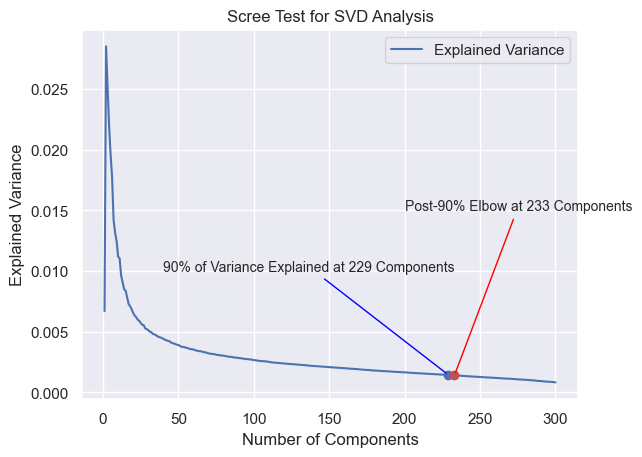

In [21]:
# Obtain Explained Variance
expl_variance = scree_matrix.explained_variance_

# Find Elbow Point
kneedle = KneeLocator(np.arange(ninety_threshold + 1, len(expl_variance)+ 1), 
                      expl_variance[ninety_threshold:], curve='convex', 
                      direction='decreasing')

elbow_location = kneedle.elbow

# Plot Elbow
sns.set_theme()

plt.plot(np.arange(1, len(expl_variance)+1),
         expl_variance[0:],
         label = "Explained Variance")

# Add Title and Axis Labels
plt.title("Scree Test for SVD Analysis")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.legend()

# Add Annotation and Point to Show Location of 90%
plt.annotate(f"90% of Variance Explained at {ninety_threshold + 1} Components", 
             xy=(ninety_threshold + 1, expl_variance[ninety_threshold]),
             xytext=(40, 0.010),
             arrowprops=dict(arrowstyle="-",
                             color = "blue"), fontsize=10)

plt.plot(ninety_threshold + 1, expl_variance[ninety_threshold], "bo",
         label = "Elbow Point")

# Add Annotation and Point to Show Location of Elbow
plt.annotate(f"Post-90% Elbow at {elbow_location} Components", 
             xy=(elbow_location, expl_variance[elbow_location - 1]),
             xytext=(200, 0.015),
             arrowprops=dict(arrowstyle="-",
                             color = "red"), fontsize=10)

plt.plot(elbow_location, expl_variance[elbow_location - 1], "ro",
         label = "Elbow Point")

#### Optimized SVD

Plotting the explained variance against the number of SVD components, we find that 90% of variance is in fact explained far past the plot's actual elbow. Finding the "post-90%" elbow and identifying it on the plot shows that it is located on the tail of the plot. It also consists of only 4 components more than the 90% variance point. Consequently, we decide to stick to our minimum variance point of 156 components with at least 90% variance as opposed to the 160 of the post-90% elbow. We believe the returns to making the model more complex are not sufficient.

We run the truncated SVD with 156 components.

In [22]:
# Create Instance of SVD with 2515 Components
svd_opt = TruncatedSVD(n_components=229, random_state = 70)

# Fit to the Matrix
lat_matrix = svd_opt.fit_transform(vector_df)

In [23]:
# Turn Into DataFrame
lat_df = pd.DataFrame(lat_matrix)

# Add Movie Labels
titles_df = pd.concat([pd.Series(vector_df.index), lat_df], axis = 1)

# Cosine Similarity
cos_similarity = cosine_similarity(titles_df.iloc[:, 1:])

content_similarity_df = pd.DataFrame(cos_similarity, index = titles_df["title"], 
             columns = titles_df["title"])

In [24]:
content_similarity_df.head()

title,FOR HONOR™,Project Zomboid,Wallpaper Engine,Call of Duty®: Black Ops III,Killing Floor 2,Conqueror's Blade,Fable Anniversary,Mortal Kombat X,ULTIMATE MARVEL VS. CAPCOM 3,Space Engineers,...,The Jackbox Party Pack 5,Atelier Totori ~The Adventurer of Arland~ DX,Nelke & the Legendary Alchemists ~Ateliers of the New World~,Atelier Meruru ~The Apprentice of Arland~ DX,Factorio,Middle-earth™: Shadow of War™,METAL GEAR SOLID V: THE PHANTOM PAIN,DOOM,TEKKEN 7,Tabletop Simulator
title,,,,,,,,,,,,,,,,,,,,,
FOR HONOR™,1.000000,0.088047,0.020098,0.113438,0.264100,0.346726,0.128146,0.258140,0.086836,0.113805,...,0.065502,0.048238,0.050030,0.035461,0.065717,0.251607,0.074670,0.123602,0.215390,0.132406
Project Zomboid,0.088047,1.000000,0.063974,0.179350,0.302672,0.083546,0.125844,0.058303,0.058032,0.262830,...,0.050819,0.071288,0.077439,0.071711,0.208825,0.098009,0.069844,0.074198,0.093617,0.166954
Wallpaper Engine,0.020098,0.063974,1.000000,0.058731,0.094024,0.017387,0.062970,0.058822,0.016435,0.061948,...,0.033323,0.035140,0.028000,0.034489,0.084120,0.031560,0.051011,0.058769,0.051887,0.089394
Call of Duty®: Black Ops III,0.113438,0.179350,0.058731,1.000000,0.455195,0.070240,0.078763,0.150262,0.076088,0.091639,...,0.064571,0.035053,0.028861,0.030783,0.102326,0.107903,0.141422,0.220433,0.129349,0.123840
Killing Floor 2,0.264100,0.302672,0.094024,0.455195,1.000000,0.129149,0.079335,0.297602,0.089677,0.211708,...,0.084377,0.033044,0.030961,0.033787,0.146114,0.133252,0.078825,0.380317,0.128693,0.245497


In [25]:
# Save df to file
content_similarity_df.to_csv('data/content_base.csv', index = True)

In [26]:
# Delete Unnecessary DataFrames
del textual_df
del svd
del lat_df

## User Similarity

In [27]:
# Import the user DataFrame
user_df = pd.read_csv("data/final_df.csv", 
                       usecols = ["appid", "title", "user_id",
                                 "y", "reviews"])

# Turn Booleans to Integers
user_df["y"] = user_df["y"].astype(int).replace(0, -1)

In [32]:
# Create DF for users with only 1 review and more than 1 
two_plus_df = user_df[user_df['reviews'] > 1].reset_index(drop = True)
one_rev_df = user_df[user_df['reviews'] == 1].reset_index(drop = True)

# print the resulting dataframe
if (len(user_df) == (len(two_plus_df) + len(one_rev_df))):
    print("No Datapoints Lost")

No Datapoints Lost


In [3]:
# Create Pivot Table
rec_pivot = user_df.pivot_table(index = "user_id", columns = "title",
                   values = "y")

# Fill NaNs
rec_pivot = rec_pivot.fillna(0)

# Convert DataFrame to Sparse Matrix
sparse_recs = csr_matrix(rec_pivot.values)

In [6]:
# Create Instance of SVD with 250 Components
user_svd = TruncatedSVD(n_components=250, random_state = 70)

# Fit to the Matrix
user_svd_fit = user_svd.fit(sparse_recs)

In [10]:
# Find Cumulative Explained Variance Percentage
user_cum_variance = np.cumsum(user_svd_fit.explained_variance_ratio_)

# Identify First Instance of Expl. Variance Above 90%
user_ninety_threshold = np.argmax(user_cum_variance >= 0.9) 

print(f"The number of features required to explain at least 90% of variance is {user_ninety_threshold + 1}")

The number of features required to explain at least 90% of variance is 157


In [ ]:
# Obtain Explained Variance
expl_variance = scree_matrix.explained_variance_

# Find Elbow Point
kneedle = KneeLocator(np.arange(ninety_threshold + 1, len(expl_variance)+ 1), 
                      expl_variance[ninety_threshold:], curve='convex', 
                      direction='decreasing')

elbow_location = kneedle.elbow

# Plot Elbow
sns.set_theme()

plt.plot(np.arange(1, len(expl_variance)+1),
         expl_variance[0:],
         label = "Explained Variance")

# Add Title and Axis Labels
plt.title("Scree Test for SVD Analysis")
plt.ylabel("Explained Variance")
plt.xlabel("Number of Components")
plt.legend()

# Add Annotation and Point to Show Location of 90%
plt.annotate(f"90% of Variance Explained at {ninety_threshold + 1} Components", 
             xy=(ninety_threshold + 1, expl_variance[ninety_threshold]),
             xytext=(40, 0.010),
             arrowprops=dict(arrowstyle="-",
                             color = "blue"), fontsize=10)

plt.plot(ninety_threshold + 1, expl_variance[ninety_threshold], "bo",
         label = "Elbow Point")

# Add Annotation and Point to Show Location of Elbow
plt.annotate(f"Post-90% Elbow at {elbow_location} Components", 
             xy=(elbow_location, expl_variance[elbow_location - 1]),
             xytext=(200, 0.015),
             arrowprops=dict(arrowstyle="-",
                             color = "red"), fontsize=10)

plt.plot(elbow_location, expl_variance[elbow_location - 1], "ro",
         label = "Elbow Point")

In [ ]:
transformed_recs = user_svd_fit.transform(sparse_recs)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [70]:
user_similarity_df = "a"

## Feature Creation

Finally, we create a brand new feature in our final_df. 

In [2]:
content_similarity_df = pd.read_csv("data/content_base.csv", index_col = "name")

NameError: name 'pd' is not defined

In [33]:
two_plus_df

,y,user_id,title,appid,reviews
0,-1,140776,FOR HONOR™,304390,2
1,-1,140776,Project Zomboid,108600,2
2,-1,4222787,FOR HONOR™,304390,16
3,1,4222787,Wallpaper Engine,431960,16
4,-1,4222787,Call of Duty®: Black Ops III,311210,16
...,...,...,...,...,...
4000244,-1,5740669,Nioh: Complete Edition,485510,2
4000245,1,1589339,Nioh: Complete Edition,485510,2
4000246,1,4593723,Nioh: Complete Edition,485510,5
4000247,1,4169158,Nioh: Complete Edition,485510,2


In [48]:
AverageSimilarityCalculator(4222787, "Call of Duty®: Black Ops III")

-0.11343754978168258 0.05873060183691747 0.45519529118254126 -0.07024015819363252 0.07876251070231319 -0.15026204072113936 0.0760879348542573


0.047833798554224975

In [47]:
# Find Average Similarity
def AverageSimilarityCalculator(user, game):
    
    user_ratings = two_plus_df[two_plus_df["user_id"] == user]
    other_games = user_ratings[user_ratings['title'] != game]
    
    other_games_titles = other_games['title']
    filtered_game_similarity_df = content_similarity_df.loc[game, other_games_titles] * other_games.set_index('title')["y"]
    
    print(* other_games.set_index('title')["y"] *  content_similarity_df.loc[game, other_games_titles])
    
    return filtered_game_similarity_df.mean()

# Create Compiler of Avg Sim
def SimilarityGenerator(users = two_plus_df, 
                     similarity = content_similarity_df):
    
    similarities = []
    for i in range(0, len(users)):
        
        sim = AverageSimilarityCalculator(users.at[i, 'user_id'],
                      users.at[i, 'title'])
        
        similarities.append(sim)
    
    return similarities

In [ ]:
def SimilarityGenerator(users = two_plus_df, 
                     similarity = content_similarity_df,
                     n_jobs=1):
    
    similarities = Parallel(n_jobs=n_jobs)(
        delayed(AverageSimilarityCalculator)(
            users.at[i, 'user_id'],
            users.at[i, 'title'],
            similarity,
            users
        ) for i in range(len(users))
    )
    
    return similarities

In [71]:
# Find Most Similary User
def UserPairer(user,
              user_similarity = user_similarity_df):
    
    return user_similarity_df.loc[user].idxmax()
    
# Create Similarity Imputer
def SimilarityImputer(users = one_rev_df):
    
    sim_list = []
    for i in range(0, len(users)):
        similar_user = UserPairer(users.at[i, "user_id"])
        
        sim = AverageSimilarityCalculator(similar_user,
                                   users.at[i, "title"])
        
        sim_list.append(sim_list)
    
    return sim_list